In [47]:
import numpy as np
import matplotlib.pyplot as plt

Ex = np.loadtxt("../main_files/Ex_t.dat")
f = np.loadtxt("../main_files/f.dat")
t = np.arange(Ex.shape[0])


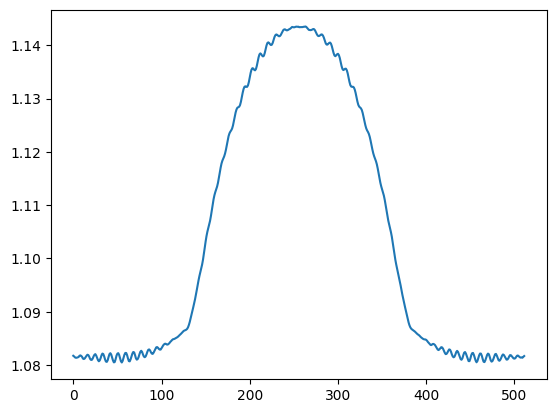

In [46]:
plt.plot(f[9000,:])

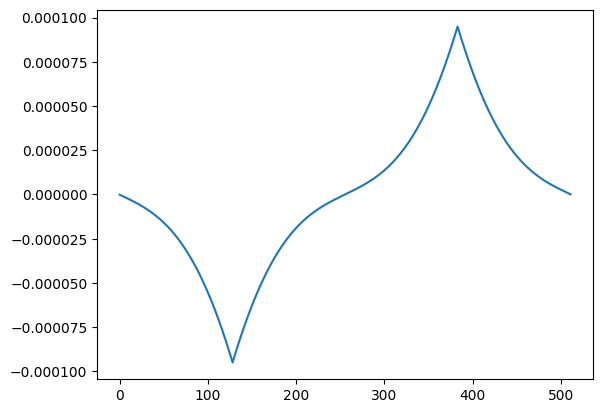

In [41]:
plt.plot(Ex[2900,:])


In [55]:
t_fit = t[10:50]
logE = np.log(Emax[10:50])

coef = np.polyfit(t_fit, logE, 1)
gamma_num = coef[0]

print("measured gamma =", gamma_num)

measured gamma = 0.03632814946244517


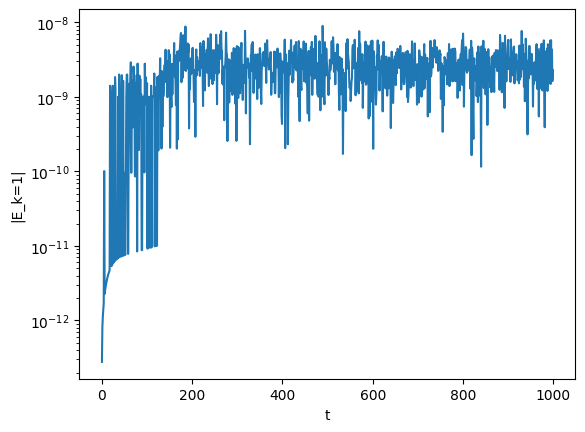

In [32]:
Exk = np.fft.fft(Ex, axis=1)
Ek1 = np.abs(Exk[:,20])

plt.semilogy(t, Ek1)
plt.xlabel("t")
plt.ylabel("|E_k=1|")
plt.show()


MovieWriter ffmpeg unavailable; using Pillow instead.


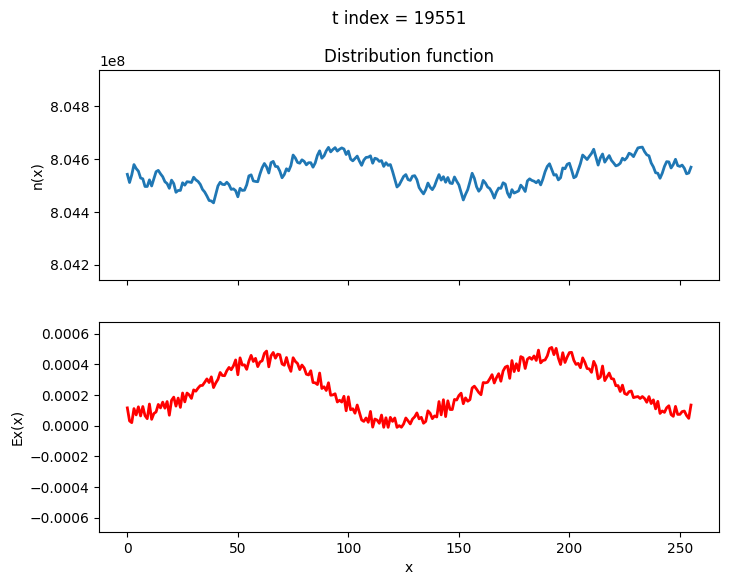

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# ======================
# データ読み込み
# ======================
Ex = np.loadtxt("../main_files/Ex_t.dat")
f  = np.loadtxt("../main_files/f.dat")

# 平均除去（強く推奨）
# Ex = Ex - Ex.mean(axis=1, keepdims=True)

Nt, Nx = Ex.shape
x = np.arange(Nx)

# ======================
# アニメーション設定
# ======================
stride   = 49      # ← 何ステップごとに1コマ使うか
nframes  = 400    # ← 作りたいコマ数
interval = 50     # ms

max_frames = Nt // stride
nframes = min(nframes, max_frames)

frames = stride * np.arange(nframes)

# ======================
# 図の初期化
# ======================
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

line_f, = axes[0].plot(x, f[frames[0]], lw=2)
axes[0].set_ylabel("n(x)")
axes[0].set_title("Distribution function")

line_E, = axes[1].plot(x, Ex[frames[0]], lw=2, color='r')
axes[1].set_ylabel("Ex(x)")
axes[1].set_xlabel("x")

# 軸固定（超重要）
axes[0].set_ylim(f.min(), f.max())
axes[1].set_ylim(Ex.min(), Ex.max())

# ======================
# 更新関数
# ======================
def update(i):
    it = frames[i]
    line_f.set_ydata(f[it])
    line_E.set_ydata(Ex[it])
    fig.suptitle(f"t index = {it}")
    return line_f, line_E

# ======================
# アニメーション生成
# ======================
ani = FuncAnimation(
    fig, update,
    frames=nframes,
    interval=interval,
    blit=True
)

ani.save("f_and_E_stride5.gif", fps=20)



In [3]:
import struct
import numpy as np
import cv2
from IPython.display import display, Image, HTML
import glob
import imageio

# =============================
#   描画パラメータ
# =============================
XMIN, XMAX = 0, 256*0.5*3.3
YMIN, YMAX = -16.5, 16.5
RES = 800  # 画像解像度

def load_frame(FNAME):
    with open(FNAME, "rb") as f:
        Nx = struct.unpack("q", f.read(8))[0]
        Ny = struct.unpack("q", f.read(8))[0]

        vx_all = np.zeros((Nx,Ny,4))
        vy_all = np.zeros((Nx,Ny,4))
        val_all = np.zeros((Nx,Ny))

        for i in range(Nx):
            for j in range(Ny):
                vx = struct.unpack("4d", f.read(32))
                vy = struct.unpack("4d", f.read(32))
                val = struct.unpack("d",  f.read(8))[0]

                vx_all[i,j] = vx
                vy_all[i,j] = vy
                val_all[i,j] = val

    return vx_all, vy_all, val_all


def world_to_img(x, y):
    ix = int((x - XMIN) / (XMAX - XMIN) * RES)
    iy = int((YMAX - y) / (YMAX - YMIN) * RES)
    return (ix, iy)


def frame_to_image(vx_all, vy_all, val_all):
    # normalize values
    vmin, vmax = val_all.min(), val_all.max()
    print("max:",vmax/0.7769748367466968)
    val_norm = (val_all - vmin) / (vmax - vmin + 1e-12)
    val_norm *= 255

    Nx, Ny = val_all.shape

    img = np.zeros((RES, RES, 3), dtype=np.uint8)

    for i in range(Nx):
        for j in range(Ny):
            pts = np.array([
                world_to_img(vx_all[i,j,k], vy_all[i,j,k])
                for k in range(4)
            ], np.int32)

            color = int(val_norm[i,j])
            cv2.fillPoly(img, [pts], (0,0,color))

    return img

# =============================
#   アニメーション作成
# =============================

files = sorted(glob.glob("../output/two_stream/*.bin"), key=lambda s: int(s.split('/')[-1].split('.')[0]))
frames = []

for i, fn in enumerate(files):
    if i%8 != 0 :
        continue
    print(f"loading {fn} ({i+1}/{len(files)})")
    vx, vy, val = load_frame(fn)
    img = frame_to_image(vx, vy, val)
    frames.append(img)

# GIF 保存
gif_path = "../output/two_stream_instability.gif"
fps = 15

imageio.mimsave(gif_path, frames, fps=fps)

print(f"GIF saved to {gif_path}")


loading ../output/two_stream/0.bin (1/10000)
max: 1180900.9106471387
loading ../output/two_stream/8.bin (9/10000)
max: 1180700.5224622504
loading ../output/two_stream/16.bin (17/10000)
max: 1180698.7258866772
loading ../output/two_stream/24.bin (25/10000)
max: 1180676.5647761824
loading ../output/two_stream/32.bin (33/10000)
max: 1180693.0420858054
loading ../output/two_stream/40.bin (41/10000)
max: 1180696.4975785122
loading ../output/two_stream/48.bin (49/10000)
max: 1180730.579767642
loading ../output/two_stream/56.bin (57/10000)
max: 1180756.3860002246
loading ../output/two_stream/64.bin (65/10000)
max: 1180766.9550610294
loading ../output/two_stream/72.bin (73/10000)
max: 1180762.8213673055
loading ../output/two_stream/80.bin (81/10000)
max: 1180746.3734384961
loading ../output/two_stream/88.bin (89/10000)
max: 1180726.7381142438
loading ../output/two_stream/96.bin (97/10000)
max: 1180726.5606486453
loading ../output/two_stream/104.bin (105/10000)
max: 1180725.2457238585
loading .

In [6]:
Ex.shape

(20000, 256)

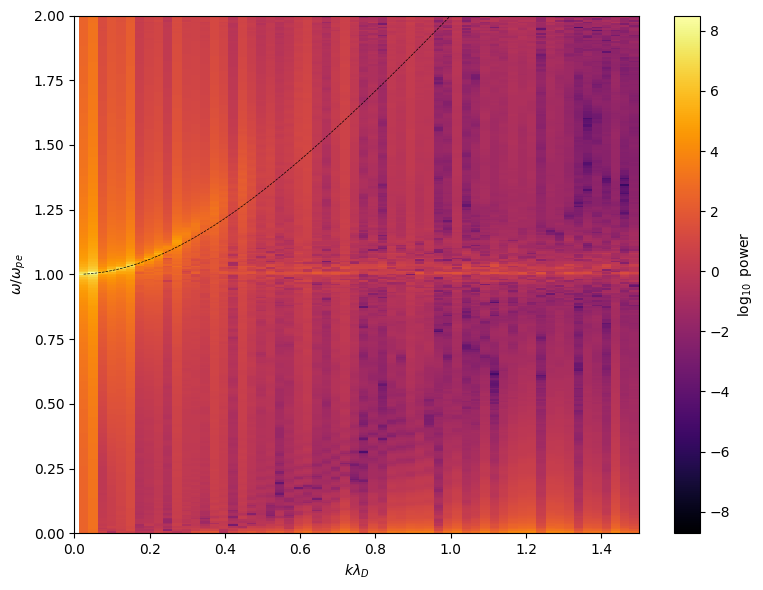

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# ======================
# 物理パラメータ
# ======================
c = 3e8
omega_pe = 564102.5
v_th = 0.003 * c
debye_length = v_th / omega_pe

dx = 0.99 * debye_length
dt = 0.01 / omega_pe

# ======================
# データ読み込み
# ======================
Ex = np.loadtxt("../main_files/Ex_t.dat")  # (Nt, Nx)
Nt, Nx = Ex.shape

# ======================
# 必須①：時間平均除去（ω=0対策）
# ======================
Ex = Ex - Ex.mean(axis=0, keepdims=True)

# ======================
# FFT
# ======================
E_k = np.fft.fft(Ex, axis=1)
k = 2*np.pi*np.fft.fftfreq(Nx, d=dx)

E_wk = np.fft.fft(E_k, axis=0)
omega = 2*np.pi*np.fft.fftfreq(Nt, d=dt)

power = np.abs(E_wk)**2

# ======================
# 必須②：ω>0 のみ
# ======================
om_mask = omega > 0
k_mask = k > 0

omega = omega[om_mask]
k = k[k_mask]
power = power[np.ix_(om_mask, k_mask)]

# ======================
# kごと正規化
# ======================
#power /= power.max(axis=0, keepdims=True)

# ======================
# log 表示
# ======================
log_power = np.log10(power + 1e-12)

# ======================
# 軸の選択
# ======================
use_normalized_axis = True

omega_analysis = np.sqrt(1. + 3.*((k*debye_length)**2))*omega_pe

if use_normalized_axis:
    k_plot = k * debye_length
    omega_plot = omega / omega_pe
    omega_analysis_plot = omega_analysis / omega_pe
    xlabel = r"$k\lambda_D$"
    ylabel = r"$\omega/\omega_{pe}$"
    #ylim = (0, 2.0)
else:
    k_plot = k
    omega_plot = omega
    omega_analysis_plot = omega_analysis
    xlabel = r"$k\,[\mathrm{rad/m}]$"
    ylabel = r"$\omega\,[\mathrm{rad/s}]$"
    ylim = (0, omega.max())

# ======================
# 描画
# ======================
plt.figure(figsize=(8,6))
plt.pcolormesh(k_plot, omega_plot, log_power,
               shading="auto", cmap="inferno")
plt.colorbar(label=r"$\log_{10}$ power")
plt.plot(k_plot, omega_analysis_plot, 
         color="black", lw = 0.5,
         linestyle="--", label="Theory (Bohm-Gross)")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xlim((0.,1.5))
plt.ylim((0.,2.))
plt.tight_layout()
plt.show()
